<h1 align="center">BENCHMARK - NOTEBOOK<br>Tester <strong>Smart</strong> Few-Shot Strategies </h1>

In [12]:
%pip install langchain langchain-mistralai python-dotenv pandas tqdm langchain-ollama matplotlib seaborn sentence-transformers scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [13]:
model_name = "ministral-3:3b"
model_name = "qwen2.5-coder:7b"

In [14]:
import os
import pandas as pd
from dotenv import load_dotenv
from langchain_ollama import ChatOllama
import json
import datetime
from tqdm import tqdm
from langchain_core.prompts import ChatPromptTemplate
import requests
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

loaded = load_dotenv() 
llm = ChatOllama(
    model=model_name,
    temperature=0.2
    )
print(f"Modèle configuré : {llm.model}")


Modèle configuré : qwen2.5-coder:7b


In [15]:
default_prompt = """Tu es un expert en administration de moteurs de recherche Solr.
Ta tâche est de traduire des demandes en langage naturel en requêtes Solr syntaxiquement parfaites.

### 1. SCHÉMA DE DONNÉES DISPONIBLE
Tu ne dois utiliser QUE les champs suivants. N'invente aucun autre champ.
- doc_type (string) : Type de document (ex: facture, devis, incident, contrat, rapport, commande).
- fournisseur (string) : Nom de l'entité tierce (ex: Haribo, Lutti, Interne).
- montant (float) : Valeur numérique.
- date_creation (date) : Date du document.
- date_modif (date) : Date de modification.
- statut (string) : État du document (ex: Validé, Clôturé, Impayée, Critique).
- assigne_a (string) : Personne responsable (ex: Martin).
- projet (string) : Nom du projet.
- ligne (string) : Identifiant de ligne de production.
- priorite (string) : Niveau d'urgence.
- texte_complet (text) : Pour la recherche floue de mots-clés.

### 2. RÈGLES DE SYNTAXE CRITIQUES
- **Booléens** : Utilise TOUJOURS les opérateurs en majuscules : AND, OR.
- **Plages** : Utilise les crochets `[MIN TO MAX]`. Pour l'infini, utilise `*` (ex: `[500 TO *]`).
- **Dates** : Utilise les mathématiques de date Solr.
    - "Mois dernier" -> `[NOW-1MONTH/MONTH TO NOW/MONTH]`
    - "Il y a moins de 7 jours" -> `[NOW-7DAYS TO NOW]`
    - "Avant le 1er Jan 2024" -> `[* TO 2024-01-01T00:00:00Z]`
- **Tri** : Si une demande implique un ordre, ajoute `&sort=champ direction` à la fin (ex: `&sort=date_creation desc`).
- **Négation** : Pour "sauf" ou "pas", utilise le signe `-` (ex: `-statut:Clôturé`).
- **Exactitude** : Ne mets pas d'espaces autour des deux points (ex: `champ:valeur`, PAS `champ : valeur`).
- **Pas de crochets pour le texte** : N'utilise JAMAIS les crochets [] pour une recherche de mot simple ou exact. Utilise champ:valeur (sans crochets) ou champ:"phrase exacte" (avec guillemets). Exemple : texte_complet:chaise (PAS texte_complet:[chaise]).

### 3. INSTRUCTION FINALE
Ne fournis AUCUNE explication, pas de markdown, pas de phrase d'introduction.
Renvoie **uniquement** la chaîne de requête brute."""

###  Algorithmes de Sélection d'Exemples (In-Context Learning)

Cette section implémente les fonctions nécessaires pour injecter dynamiquement des exemples dans le System Prompt.

**Composants clés :**
* `build_final_prompt(base, examples)` : Assemble le prompt final en concaténant les instructions et les exemples choisis.
* `get_random_examples(bank, k)` : Sélection naïve pour la baseline.
* `SmartExampleSelector` : Classe utilisant **Chroma/SentenceTransformers** pour effectuer une recherche de similarité sémantique (k-NN) entre l'input utilisateur et la banque d'exemples.

In [16]:
dataset_name = "exemple_banque.json"
with open(dataset_name, "r", encoding="utf-8") as f:
    example_bank = json.load(f)

In [17]:
def build_final_prompt(base_prompt, selected_examples):
    """
    Assemble le prompt système de base avec les exemples choisis.
    """
    if not selected_examples:
        return base_prompt

    # On ajoute une section Exemples
    full_prompt = base_prompt + "\n\n### 4. EXEMPLES (FEW-SHOT)\n"
    
    for ex in selected_examples:
        full_prompt += f"Input: {ex['input']}\n"
        full_prompt += f"Output: {ex['output']}\n\n"
        
    return full_prompt

# ---  SÉLECTEUR ALÉATOIRE (Random) ---
def get_random_examples(bank, k=3):
    """
    Récupère k exemples au hasard dans la banque.
    """
    if k >= len(bank):
        return bank
    return random.sample(bank, k)

# --- SÉLECTEUR INTELLIGENT (RAG / k-NN) ---
class SmartExampleSelector:
    def __init__(self, example_bank):
        """
        Initialise le modèle et pré-calcule les embeddings (vecteurs) de la banque d'exemples.
        Cela prend quelques secondes au premier lancement.
        """
        print("Chargement du modèle d'embedding (all-MiniLM-L6-v2)...")
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.bank = example_bank
        
        # On extrait juste les questions (inputs) pour le calcul vectoriel
        self.bank_inputs = [ex['input'] for ex in example_bank]
        
        print(f"Vectorisation de {len(self.bank)} exemples...")
        self.bank_embeddings = self.model.encode(self.bank_inputs)
        print("Prêt.")

    def get_k_nearest(self, user_query, k=3):
        """
        Compare la question de l'utilisateur avec la banque et renvoie les k plus proches.
        """
        # 1. On transforme la question utilisateur en vecteur
        query_embedding = self.model.encode([user_query])
        
        # 2. Calcul de similarité Cosine entre la question et TOUS les exemples
        similarities = cosine_similarity(query_embedding, self.bank_embeddings)[0]
        
        # 3. On trie les indices par score décroissant (les plus proches d'abord)
        # argsort renvoie les indices triés du plus petit au plus grand, donc on inverse [::-1]
        top_indices = similarities.argsort()[::-1][:k]
        
        # 4. On récupère les exemples correspondants
        selected = [self.bank[i] for i in top_indices]
        
        # print(f"DEBUG - Question: {user_query}")
        # print(f"DEBUG - Top Match ({similarities[top_indices[0]]:.2f}): {selected[0]['input']}")
        
        return selected


smart_selector = SmartExampleSelector(example_bank)

Chargement du modèle d'embedding (all-MiniLM-L6-v2)...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Vectorisation de 39 exemples...
Prêt.


In [18]:
SOLR_URL = "http://localhost:8983/solr/benchmark_core/select"
SAMPLE_SIZE = 25  # Nombre de questions à tester
dataset_path = "benchmark_dataset.json"

In [19]:
strategies = [
    {"name": "1_Zero_Shot",   "type": "none",   "k": 0},
    {"name": "2_Random_3",    "type": "random", "k": 3},
    {"name": "3_Random_20",   "type": "random", "k": 20},
    {"name": "4_Smart_3",     "type": "smart",  "k": 3},
    {"name": "5_Smart_5",     "type": "smart",  "k": 5}
]

def query_solr(query_str):
    """Exécute la requête sur Solr et renvoie les IDs"""
    if not query_str or "ERROR" in query_str: return None
    params = {'fl': 'id', 'rows': 1000, 'wt': 'json'}
    try:
        # Parsing basique des params URL (&sort=, &rows=)
        if '&' in query_str:
            parts = query_str.split('&')
            params['q'] = parts[0]
            for part in parts[1:]:
                if '=' in part:
                    key, val = part.split('=', 1)
                    params[key] = val
        else:
            params['q'] = query_str
            
        r = requests.get(SOLR_URL, params=params, timeout=2)
        if r.status_code == 200:
            return [d['id'] for d in r.json().get('response', {}).get('docs', [])]
    except:
        pass
    return None

def compare_ids(expected, generated, check_order=False):
    if expected is None or generated is None: return False
    if check_order: return expected == generated
    return set(expected) == set(generated)

with open(dataset_path, 'r', encoding='utf-8') as f:
    full_dataset = json.load(f)

test_subset = random.sample(full_dataset, min(SAMPLE_SIZE, len(full_dataset)))
total_steps = len(test_subset) * len(strategies)
print(f"Total appels LLM : {total_steps}")

results_data = []

with tqdm(total=total_steps, desc="Progression Benchmark") as pbar:
    
    for entry in tqdm(test_subset, desc="Traitement des questions"):
        question = entry["question"]
        expected_solr = entry["expected_solr"]
        difficulty = entry["difficulty"]
        
        ids_expected = query_solr(expected_solr)
        
        for strat in strategies:
            
            selected_examples = []
            if strat["type"] == "random":
                selected_examples = get_random_examples(example_bank, k=strat["k"])
            elif strat["type"] == "smart":
                selected_examples = smart_selector.get_k_nearest(question, k=strat["k"])
            
            final_system_prompt = build_final_prompt(default_prompt, selected_examples)
            
            try:
                prompt_template = ChatPromptTemplate.from_messages([
                    ("system", final_system_prompt),
                    ("user", "{question}")
                ])
                chain = prompt_template | llm
                
                response = chain.invoke({"question": question})
                generated_raw = response.content.strip()
                
                generated_clean = generated_raw.replace("```solr", "").replace("```", "").strip("`").strip()
                
            except Exception as e:
                generated_clean = f"ERROR: {e}"
    
            ids_generated = query_solr(generated_clean)
            
            is_sort = "sort" in difficulty
            is_exec_match = compare_ids(ids_expected, ids_generated, check_order=is_sort)
            
            results_data.append({
                "question_id": entry["id"],
                "difficulty": difficulty,
                "question": question,
                "strategy_name": strat["name"],
                "strategy_type": strat["type"],
                "k_examples": strat["k"],
                "expected_solr": expected_solr,
                "generated_solr": generated_clean,
                "is_exact_match": (generated_clean == expected_solr), # Comparaison texte
                "execution_match": is_exec_match,                     # Comparaison réelle Solr
                "solr_error": (ids_generated is None),
                "used_examples": [ex['input'] for ex in selected_examples] if selected_examples else []
            })
    
            pbar.set_postfix({"Strat": strat["name"], "Diff": difficulty}) # Affiche la stratégie en cours
            pbar.update(1)

date_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
filename = f"few_shot_benchmark_results_{date_str}.json"

with open(filename, "w", encoding="utf-8") as f:
    json.dump(results_data, f, indent=4, ensure_ascii=False)

print(f"\nTerminé ! Résultats sauvegardés dans : {filename}")

Total appels LLM : 125


Progression Benchmark: 100%|██████████| 125/125 [24:13<00:00, 11.63s/it, Strat=5_Smart_5, Diff=sort]


Terminé ! Résultats sauvegardés dans : few_shot_benchmark_results_2026-02-11_17-06.json


/tmp/ipykernel_51213/209736550.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Graphique sauvegardé : few_shot_benchmark_results_2026-02-11_17-06.png


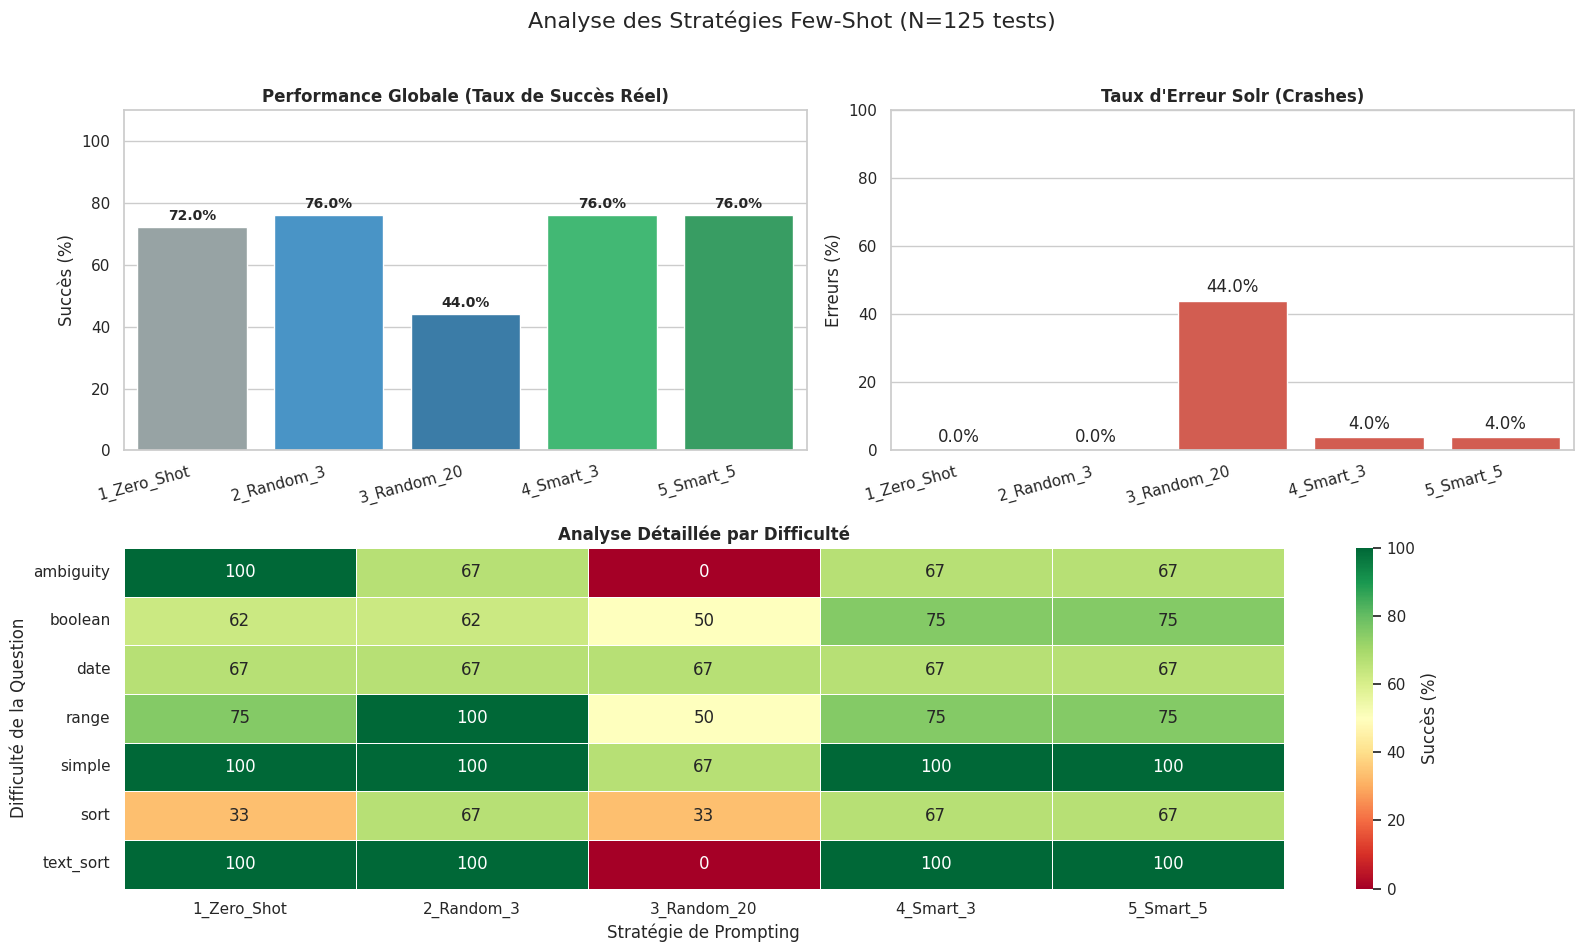

In [20]:
# Vérification de l'existence du fichier
if not os.path.exists(filename):
    print(f"Erreur : Le fichier '{filename}' est introuvable. Veuillez vérifier le nom ou lancer l'étape précédente.")
else:
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Création du DataFrame
    df = pd.DataFrame(data)

    # --- 2. PRÉPARATION DES DONNÉES ---

    # Conversion en pourcentage
    df['score'] = df['execution_match'].astype(int) * 100
    df['error'] = df['solr_error'].astype(int) * 100
    
    # Palette de couleurs personnalisée
    # Zero-Shot = Gris, Random = Bleu, Smart = Vert
    palette_colors = {
        "1_Zero_Shot": "#95a5a6", # Gris
        "2_Random_3": "#3498db",  # Bleu clair
        "3_Random_20": "#2980b9", # Bleu foncé
        "4_Smart_3": "#2ecc71",   # Vert clair
        "5_Smart_5": "#27ae60"    # Vert foncé
    }
    
    # --- 3. GÉNÉRATION DES GRAPHIQUES ---
    sns.set_theme(style="whitegrid")
    
    # Création d'une figure avec 3 sous-graphiques (2 en haut, 1 en bas)
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2)
    
    ax1 = fig.add_subplot(gs[0, 0]) # Haut Gauche
    ax2 = fig.add_subplot(gs[0, 1]) # Haut Droite
    ax3 = fig.add_subplot(gs[1, :]) # Bas (Toute la largeur)

    fig.suptitle(f"Analyse des Stratégies Few-Shot (N={len(df)} tests)", fontsize=16, y=0.95)

    # --- GRAPHIQUE A : LEADERBOARD GLOBAL (Taux de succès) ---
    global_scores = df.groupby('strategy_name')['score'].mean().reset_index()
    
    sns.barplot(
        x='strategy_name', 
        y='score', 
        data=global_scores, 
        palette=palette_colors, 
        ax=ax1
    )
    
    ax1.set_title("Performance Globale (Taux de Succès Réel)", fontsize=12, fontweight='bold')
    ax1.set_ylabel("Succès (%)")
    ax1.set_xlabel("")
    ax1.set_ylim(0, 110)
    plt.setp(ax1.get_xticklabels(), rotation=15, ha='right')
    
    # Ajout des étiquettes de valeur
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.1f%%', padding=3, fontsize=10, fontweight='bold')


    # --- GRAPHIQUE B : IMPACT SUR LES ERREURS (Robustesse) ---
    error_scores = df.groupby('strategy_name')['error'].mean().reset_index()
    
    sns.barplot(
        x='strategy_name', 
        y='error', 
        data=error_scores, 
        color="#e74c3c", # Rouge pour les erreurs
        ax=ax2
    )
    
    ax2.set_title("Taux d'Erreur Solr (Crashes)", fontsize=12, fontweight='bold')
    ax2.set_ylabel("Erreurs (%)")
    ax2.set_xlabel("")
    ax2.set_ylim(0, 100)
    plt.setp(ax2.get_xticklabels(), rotation=15, ha='right')
    
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.1f%%', padding=3)


    # --- GRAPHIQUE C : HEATMAP PAR DIFFICULTÉ (Détail) ---
    # Pivot des données : Lignes=Difficulté, Colonnes=Stratégie
    pivot_table = df.pivot_table(index='difficulty', columns='strategy_name', values='score', aggfunc='mean')
    
    sns.heatmap(
        pivot_table, 
        annot=True, 
        fmt=".0f", 
        cmap="RdYlGn", # Rouge -> Jaune -> Vert
        vmin=0, vmax=100, 
        linewidths=.5,
        cbar_kws={'label': 'Succès (%)'},
        ax=ax3
    )
    
    ax3.set_title("Analyse Détaillée par Difficulté", fontsize=12, fontweight='bold')
    ax3.set_xlabel("Stratégie de Prompting")
    ax3.set_ylabel("Difficulté de la Question")


    plt.tight_layout(rect=[0, 0, 1, 0.93]) # Ajustement pour le titre principal
    
    # Sauvegarde
    filename_png = filename.replace(".json", ".png")
    plt.savefig(filename_png)
    print(f"Graphique sauvegardé : {filename_png}")
    
    plt.show()